# Import Libraries

In [12]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Layer
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
import optuna
from optuna.integration import TFKerasPruningCallback, XGBoostPruningCallback
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully
TensorFlow version: 2.20.0


# Load MIMIC Perform AF Dataset

**Dataset info:**
- AF: 16 pasien (mimic_perform_af_001 - mimic_perform_af_016)
- Non-AF: 16 pasien (mimic_perform_non_af_001 - mimic_perform_non_af_016)
- Sampling Rate: 125Hz
- Duration: ~20 menit per pasien (150,000 samples)
- Columns: Time, PPG, ECG, resp

In [13]:
# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

# List files - Balance: AF only up to patient 16
af_files_all = sorted(glob.glob(os.path.join(af_folder, '*_data.csv')))
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*_data.csv')))

print("="*60)
print("DATASET: MIMIC Perform AF (Balanced)")
print("="*60)
print(f"\n📁 AF Folder: {af_folder}")
print(f"   Patients: {len(af_files_all)}")
print(f"\n📁 Non-AF Folder: {nonaf_folder}")
print(f"   Patients: {len(nonaf_files)}")
print(f"\n📊 Total Patients: {len(af_files_all) + len(nonaf_files)}")

DATASET: MIMIC Perform AF (Balanced)

📁 AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\af
   Patients: 19

📁 Non-AF Folder: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\non-af
   Patients: 16

📊 Total Patients: 35


## Train-Test Split (Sesuai Jurnal: 65% Train, 35% Test)

Split berdasarkan pasien untuk menghindari data leakage

In [14]:
# Split 65% train, 35% test (sesuai jurnal)
# Split per kelas untuk menjaga proporsi

np.random.seed(42)

# Shuffle files
af_files_shuffled = np.random.permutation(af_files_all).tolist()
nonaf_files_shuffled = np.random.permutation(nonaf_files).tolist()

# Split AF: 65% train, 35% test
n_af_train = int(len(af_files_all) * 0.65)
train_af = af_files_shuffled[:n_af_train]
test_af = af_files_shuffled[n_af_train:]

# Split Non-AF: 65% train, 35% test
n_nonaf_train = int(len(nonaf_files) * 0.65)
train_nonaf = nonaf_files_shuffled[:n_nonaf_train]
test_nonaf = nonaf_files_shuffled[n_nonaf_train:]

print("="*60)
print("DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)")
print("="*60)
print(f"\n📊 AF Split:")
print(f"   Train: {len(train_af)} patients")
print(f"   Test: {len(test_af)} patients")
print(f"\n📊 Non-AF Split:")
print(f"   Train: {len(train_nonaf)} patients")
print(f"   Test: {len(test_nonaf)} patients")
print(f"\n📊 Total:")
print(f"   Train: {len(train_af) + len(train_nonaf)} patients")
print(f"   Test: {len(test_af) + len(test_nonaf)} patients")

DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)

📊 AF Split:
   Train: 12 patients
   Test: 7 patients

📊 Non-AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Total:
   Train: 22 patients
   Test: 13 patients


## Load Data Function

In [15]:
def load_patient_data(file_path, max_samples=150000):
    """
    Load ECG data dari file CSV.
    """
    df = pd.read_csv(file_path)
    
    # Limit samples
    if len(df) > max_samples:
        df = df.iloc[:max_samples]
    
    # Get ECG column
    ecg = df['ECG'].values
    
    # Handle NaN
    if np.any(np.isnan(ecg)):
        ecg = pd.Series(ecg).interpolate().values
    
    return ecg

print("✅ Load function defined")

✅ Load function defined


## Feature Extraction (Sesuai Jurnal)

5 fitur statistik per window:
1. Skewness
2. Kurtosis
3. Minimum
4. Maximum
5. Standard Deviation

In [16]:
# Parameters
SAMPLING_RATE = 125  # Hz
WINDOW_SIZE = SAMPLING_RATE  # 1 second = 125 samples
SEQUENCE_LENGTH = 10  # 10 windows = 10 seconds context

def extract_statistical_features(window):
    """
    Extract 5 statistical features (sesuai jurnal):
    Skewness, Kurtosis, Min, Max, STD
    """
    return np.array([
        skew(window),
        kurtosis(window),
        np.min(window),
        np.max(window),
        np.std(window)
    ])

def extract_features_from_signal(ecg_signal, window_size=125):
    """
    Extract features dari ECG signal.
    """
    n_windows = len(ecg_signal) // window_size
    features = []
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        window = ecg_signal[start:end]
        features.append(extract_statistical_features(window))
    
    return np.array(features)

print(f"📊 Parameters:")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")
print(f"   Window Size: {WINDOW_SIZE} samples (1 second)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} windows")
print(f"   Features: 5 (Skewness, Kurtosis, Min, Max, STD)")

📊 Parameters:
   Sampling Rate: 125 Hz
   Window Size: 125 samples (1 second)
   Sequence Length: 10 windows
   Features: 5 (Skewness, Kurtosis, Min, Max, STD)


## Load and Extract Features

In [17]:
def load_and_extract(files, label, desc=""):
    """
    Load files dan extract features.
    """
    all_features = []
    all_labels = []
    
    for f in files:
        patient_id = os.path.basename(f).replace('_data.csv', '')
        print(f"   Loading {patient_id}...", end=" ")
        
        # Load ECG
        ecg = load_patient_data(f)
        
        # Extract features
        features = extract_features_from_signal(ecg, WINDOW_SIZE)
        labels = np.full(len(features), label)
        
        all_features.append(features)
        all_labels.append(labels)
        
        print(f"{len(features)} windows")
    
    return np.vstack(all_features), np.concatenate(all_labels)

# Load Training Data
print("="*60)
print("LOADING TRAINING DATA")
print("="*60)

print("\n📥 Loading AF patients (Train)...")
X_train_af, y_train_af = load_and_extract(train_af, label=1)

print("\n📥 Loading Non-AF patients (Train)...")
X_train_nonaf, y_train_nonaf = load_and_extract(train_nonaf, label=0)

# Combine training data
X_train = np.vstack([X_train_af, X_train_nonaf])
y_train = np.concatenate([y_train_af, y_train_nonaf])

print("\n" + "="*60)
print("LOADING TEST DATA")
print("="*60)

print("\n📥 Loading AF patients (Test)...")
X_test_af, y_test_af = load_and_extract(test_af, label=1)

print("\n📥 Loading Non-AF patients (Test)...")
X_test_nonaf, y_test_nonaf = load_and_extract(test_nonaf, label=0)

# Combine test data
X_test = np.vstack([X_test_af, X_test_nonaf])
y_test = np.concatenate([y_test_af, y_test_nonaf])

print("\n" + "="*60)
print("✅ DATA LOADED")
print("="*60)
print(f"\n📊 Training Data:")
print(f"   Samples: {len(X_train)}")
print(f"   AF: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"\n📊 Test Data:")
print(f"   Samples: {len(X_test)}")
print(f"   AF: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.1f}%)")

LOADING TRAINING DATA

📥 Loading AF patients (Train)...
   Loading mimic_perform_af_001... 1200 windows
   Loading mimic_perform_af_006... 1200 windows
   Loading mimic_perform_af_012... 1200 windows
   Loading mimic_perform_af_002... 1200 windows
   Loading mimic_perform_af_009... 1200 windows
   Loading mimic_perform_af_017... 1200 windows
   Loading mimic_perform_af_004... 1200 windows
   Loading mimic_perform_af_014... 1200 windows
   Loading mimic_perform_af_016... 1200 windows
   Loading mimic_perform_af_018... 1200 windows
   Loading mimic_perform_af_003... 1200 windows
   Loading mimic_perform_af_010... 1200 windows

📥 Loading Non-AF patients (Train)...
   Loading mimic_perform_non_af_008... 1200 windows
   Loading mimic_perform_non_af_014... 1200 windows
   Loading mimic_perform_non_af_011... 1200 windows
   Loading mimic_perform_non_af_004... 1200 windows
   Loading mimic_perform_non_af_016... 1200 windows
   Loading mimic_perform_non_af_007... 1200 windows
   Loading mimic_p

## Preprocessing

In [18]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalized")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

✅ Features normalized
   Train shape: (26400, 5)
   Test shape: (15600, 5)


In [19]:
def create_sequences(data, labels, sequence_length=10):
    """
    Create sequences for LSTM.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
print(f"Creating sequences with {SEQUENCE_LENGTH} timesteps...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created:")
print(f"   X_train: {X_train_seq.shape}")
print(f"   X_test: {X_test_seq.shape}")

Creating sequences with 10 timesteps...

✅ Sequences created:
   X_train: (26391, 10, 5)
   X_test: (15591, 10, 5)


# Transfomer Model 

### Optuna

#### Model

In [20]:
# Build default Transformer model
def build_transformer_model_default(n_timesteps=SEQUENCE_LENGTH, n_features=5, num_heads=2, ff_dim=32, dropout_rate=0.2):
    """
    Build default Transformer model.
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=n_features)(x, x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("✅ AttentionLayer and default Transformer model defined")

✅ AttentionLayer and default Transformer model defined


#### Training

In [21]:
# Build default Transformer model with Optuna best config
model = build_transformer_model_default(
    n_timesteps=SEQUENCE_LENGTH,
    n_features=5,
    num_heads=4,
    ff_dim=128,
    dropout_rate=0.4152611622227923
)

print("Model Architecture:")
model.summary()

# Set optimizer with custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00012858379193275303)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Class weights untuk handle imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"Class weights: {class_weight_dict}")

print("\nTraining Default Transformer Model (Optuna best config)...")
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=44,
    batch_size=128,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final accuracy: {history.history['accuracy'][-1]:.4f}")

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 5)     │         10 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 5)     │        465 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 5)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      6,528 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,132 (27.86 KB)

 Trainable params: 7,132 (27.86 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(1.099625), 1: np.float64(0.9169272461955389)}

Training Default Transformer Model (Optuna best config)...
Epoch 1/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6822 - loss: 0.5899
Epoch 2/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7641 - loss: 0.4729
Epoch 3/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8139 - loss: 0.3942
Epoch 4/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8431 - loss: 0.3357
Epoch 5/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8633 - loss: 0.3006
Epoch 6/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8812 - loss: 0.2690
Epoch 7/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8974 - loss: 0.2452
Epoch 8/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9064 - loss: 0.2247
Epoch 9/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9146 - loss: 0.2097
Epoch 10/44
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9214 - loss: 0

#### Save Model

In [22]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'TRANSFORMER')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_transformer_ImbalanceData_{timestamp}.joblib')

joblib.dump(model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\TRANSFORMER\rf_transformer_ImbalanceData_10122025_120035.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

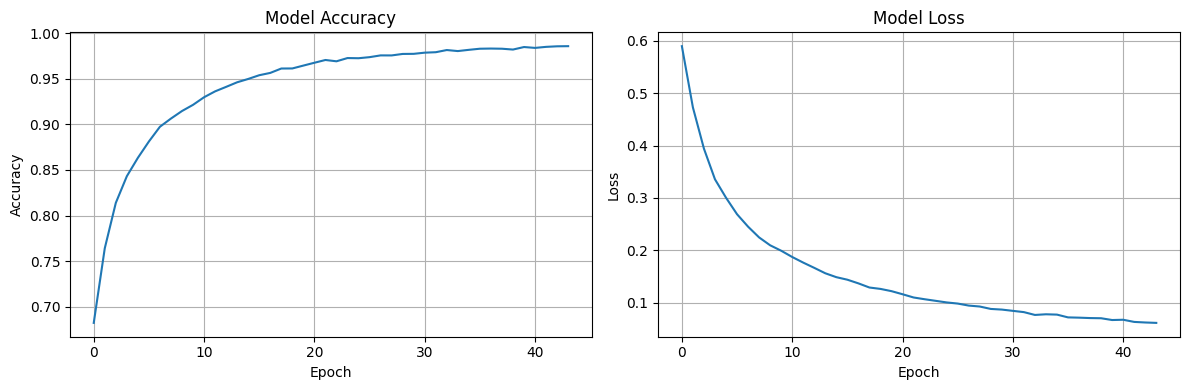

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Extract Features 

In [24]:
transformer_default_feature_extractor = Model( # Ubah nama
    inputs=model.inputs, 
    outputs=model.layers[-2].output 
)

# Extract features
print("Extracting features from Transformer model...")
X_train_weights_imbalance = transformer_default_feature_extractor.predict(X_train_seq, verbose=0) # Ubah nama
X_test_weights_imbalance = transformer_default_feature_extractor.predict(X_test_seq, verbose=0)   # Ubah nama

print("✅ Features extracted from Transformer model")
print(f"   Train: {X_train_weights_imbalance.shape}")
print(f"   Test: {X_test_weights_imbalance.shape}")

Extracting features from Transformer model...
✅ Features extracted from Transformer model
   Train: (26391, 128)
   Test: (15591, 128)


# Random Forest Classifier 

### Default

#### Model

In [25]:
rf_imbalance = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    bootstrap=True,
    random_state=42
)

#### Running

In [27]:
print("Training Random Forest Imbalance (fitur ekstraksi default)...")
rf_imbalance.fit(X_train_weights_imbalance, y_train_seq)
print("✅ Random Forest Imbalance trained")

Training Random Forest Imbalance (fitur ekstraksi default)...
✅ Random Forest Imbalance trained


#### Save Model

In [28]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\Users\Lenovo\Documents\GitHub\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'RandomForest')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_transformer_DataImbalance_{timestamp}.joblib')

joblib.dump(rf_imbalance, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\Users\Lenovo\Documents\GitHub\FP_MLxDM\models\RandomForest\rf_transformer_DataImbalance_10122025_120126.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

HYBRID MODEL EVALUATION (Default Transformer + Random Forest)
Dataset: MIMIC Perform AF

📊 Performance Metrics:
   Accuracy : 0.5155 (51.55%)
   Precision: 0.5136 (51.36%)
   Recall   : 0.5741 (57.41%)
   F1 Score : 0.5422 (54.22%)
   ROC AUC  : 0.5089 (50.89%)


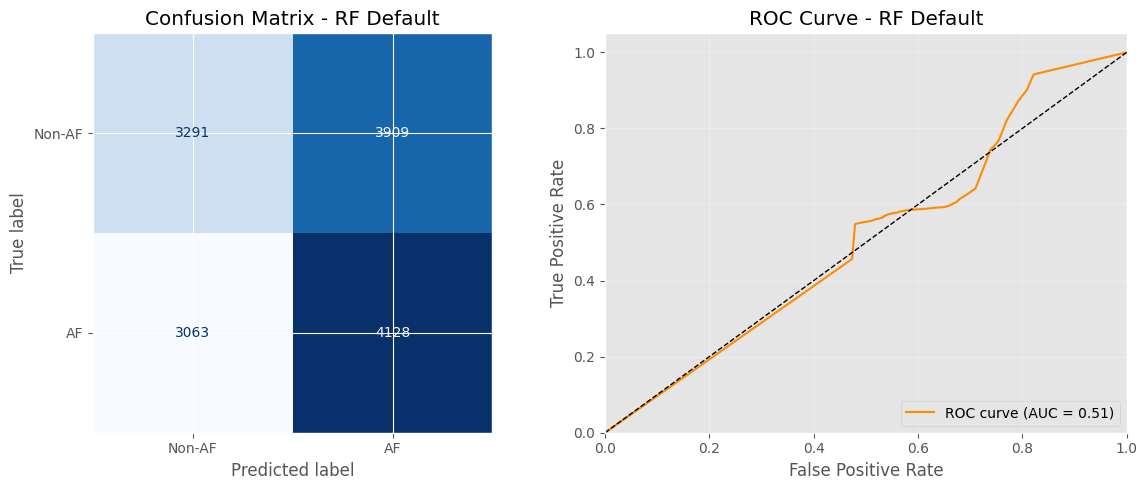


Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.52      0.46      0.49      7200
          AF       0.51      0.57      0.54      7191

    accuracy                           0.52     14391
   macro avg       0.52      0.52      0.51     14391
weighted avg       0.52      0.52      0.51     14391



In [ ]:
# Evaluate Random Forest imbalance model 

y_prob_imbalance = rf_imbalance.predict_proba(X_test_weights_imbalance)[:, 1]
y_pred_imbalance = rf_imbalance.predict(X_test_weights_imbalance)

# Metrics
acc_imbalance = accuracy_score(y_test_seq, y_pred_imbalance)
prec_imbalance = precision_score(y_test_seq, y_pred_imbalance, zero_division=0)
recall_imbalance = recall_score(y_test_seq, y_pred_imbalance, zero_division=0)
f1_imbalance = f1_score(y_test_seq, y_pred_imbalance, zero_division=0)
rocauc_imbalance = roc_auc_score(y_test_seq, y_prob_imbalance) if len(np.unique(y_pred_imbalance)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (imbalance Transformer + Random Forest)")
print("Dataset: MIMIC Perform AF")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc_imbalance:.4f} ({acc_imbalance*100:.2f}%)")
print(f"   Precision: {prec_imbalance:.4f} ({prec_imbalance*100:.2f}%)")
print(f"   Recall   : {recall_imbalance:.4f} ({recall_imbalance*100:.2f}%)")
print(f"   F1 Score : {f1_imbalance:.4f} ({f1_imbalance*100:.2f}%)")
print(f"   ROC AUC  : {rocauc_imbalance:.4f} ({rocauc_imbalance*100:.2f}%)")

# Confusion Matrix & ROC Curve side by side
cm_imbalance = confusion_matrix(y_test_seq, y_pred_imbalance)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_imbalance)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_imbalance = ConfusionMatrixDisplay(confusion_matrix=cm_imbalance, display_labels=['Non-AF', 'AF'])
disp_imbalance.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - RF imbalance')

# ROC Curve
axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {rocauc_imbalance:.2f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - RF imbalance')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred_imbalance, target_names=['Non-AF', 'AF'], zero_division=0))